In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
from go_learning_helpers import *
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter

%matplotlib notebook

Let's generate a few go_annotation datasets. 

We'll use the original annotations (post-stopwords) binarized, a single-occurence-filtered-out annotations binarized, and a single-occurence-filtered-out tfidf model.

In [2]:
generate_kinase_labels()

In [3]:

go_file = 'kinase_go_processes.csv'
go_dir = './'

# get the go annotations
go_annotations = get_go_annotations_series(go_dir+go_file)

# filter out any empty kinases
go_annotations = go_annotations[map(lambda x: len(x) > 0, [x for x in go_annotations])]

# generate binarized go_annotations
go_lab_binner, bin_go_annotations = convert_go_annotations_to_one_hot(go_annotations,
                                                   return_binarizer= True)

# create a frequency chart for every label in the go_annotations 
# this allows us to screen out labels with only one occurence (to help reduce noise)
frequency = defaultdict(int)
for doc in go_annotations:
    for word in doc:
        frequency[word] += 1
texts = [[word for word in doc if frequency[word] > 1]
         for doc in go_annotations]

# generate binarized go_annotations for the intermediate, filtered go_annotations
filter_go_annotations = pd.Series(texts)
filter_go_annotations.index = go_annotations.index
filter_go_annotations.name = go_annotations.name

# filter out any empty filter_kinases
filter_go_annotations = filter_go_annotations[map(lambda x: len(x) > 0, [x for x in filter_go_annotations])]

freq_go_lab_binner, freq_go_annotations = convert_go_annotations_to_one_hot(filter_go_annotations,
                                                   return_binarizer= True)
        
# create a corpus and dictionary (reference) objects for a tfidf model for the go_annotations
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(doc) for doc in texts]

# create a tfidf series for the go_annotations
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# we have to parse gensim's sparse format back into pd.Series format
hold = []
rej = []
for i in range(len(corpus_tfidf)):
    if(len(corpus_tfidf[i]) > 1):
        a, b = map(np.asarray, zip(*corpus_tfidf[i]))
        row = np.repeat(0, len(a))
        hold += [sp.csc_matrix((b, (row, a)), shape=(1,len(dictionary)))]
    else:
        rej += [go_annotations.index[i]]
    

tfidf_go_annotations = pd.Series([x for x in sp.vstack(hold).toarray()])
tfidf_go_annotations.index = [x for x in go_annotations.index.tolist() if x not in rej]
tfidf_go_annotations.name = go_annotations.name

# create a dictionary with our datasets
go_data_dict = {'go':bin_go_annotations,'freq':freq_go_annotations,'tfidf':tfidf_go_annotations }

Now, we need to get our cluster data and make a few DataFrames with the clusters and go_annotations attached

In [4]:
c_spinglass_file = 'consensusclusters_spinglass_greaterthan90percent.txt'
cluster_dir = '../reproduced/'

c_spinglass_data_dict = {key:add_cluster_labels(cluster_dir+c_spinglass_file,
                                  val) for key, val in go_data_dict.items()}

fast_greedy_file = 'fastgreedy_clusters.txt'

fast_greedy_data_dict = {key:add_cluster_labels(cluster_dir+fast_greedy_file,
                                  val) for key, val in go_data_dict.items()}

eigen_file = 'consensusclusters_leadingeigenvector_greaterthan90percent.txt'

eigen_data_dict = {key:add_cluster_labels(cluster_dir+eigen_file,
                                  val) for key, val in go_data_dict.items()}

Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  25 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  25 kinases due to zero length post-processing
Dropped  0 kinases due to zero length post-processing
Dropped  3 kinases due to zero length post-processing
Dropped  25 kinases due to zero length post-processing


Now, let's import a few linear classifiers

In [5]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import ComplementNB as CNB

svm = SVC(kernel='linear')
nb = GNB()
cnb = CNB()

classifiers = [svm, nb, cnb]

And get the accuracy and MCC scores for our datasets

In [6]:
validation_kwargs = {'n_run':20, 'metrics':['accuracy', 'matthews'], 'parallel':mp.cpu_count()-1, 'test_size':0.3}
c_spinglass_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in c_spinglass_data_dict.items() for clf in classifiers}
fast_greedy_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in fast_greedy_data_dict.items() for clf in classifiers}
eigen_results = {key+str(clf.__class__).split('.')[-1][0:-2]:validate_learnability(dat_df=val, clf=clf, **validation_kwargs) for key, val in eigen_data_dict.items() for clf in classifiers}

In [7]:
mean_spinglass_results = {key:np.mean(np.vstack(map(np.array, c_spinglass_results[key])), axis=0) for key in c_spinglass_results.keys()}
mean_fast_greedy_results = {key:np.mean(np.vstack(map(np.array, fast_greedy_results[key])), axis=0) for key in fast_greedy_results.keys()}
mean_eigen_results = {key:np.mean(np.vstack(map(np.array, eigen_results[key])), axis=0) for key in eigen_results.keys()}

In [8]:
mean_spinglass_results

{'goSVC': array([0.49049296, 0.40141824]),
 'goGaussianNB': array([0.49401408, 0.42577308]),
 'goComplementNB': array([0.53943662, 0.47632072]),
 'freqSVC': array([0.48404255, 0.39523411]),
 'freqGaussianNB': array([0.49113475, 0.40906535]),
 'freqComplementNB': array([0.53546099, 0.46671748]),
 'tfidfSVC': array([0.50925926, 0.41823039]),
 'tfidfGaussianNB': array([0.4837037 , 0.40103875]),
 'tfidfComplementNB': array([0.51925926, 0.448437  ])}

In [9]:
mean_fast_greedy_results

{'goSVC': array([0.53802817, 0.41397245]),
 'goGaussianNB': array([0.57323944, 0.47175206]),
 'goComplementNB': array([0.60704225, 0.51865553]),
 'freqSVC': array([0.55425532, 0.42682854]),
 'freqGaussianNB': array([0.54361702, 0.43358418]),
 'freqComplementNB': array([0.63085106, 0.54128833]),
 'tfidfSVC': array([0.56518519, 0.44390271]),
 'tfidfGaussianNB': array([0.52      , 0.39049126]),
 'tfidfComplementNB': array([0.60962963, 0.5141284 ])}

In [10]:
mean_eigen_results

{'goSVC': array([0.6415493 , 0.11121367]),
 'goGaussianNB': array([0.59401408, 0.0798847 ]),
 'goComplementNB': array([0.53908451, 0.20114839]),
 'freqSVC': array([0.66737589, 0.19831927]),
 'freqGaussianNB': array([0.59326241, 0.0876235 ]),
 'freqComplementNB': array([0.58617021, 0.24518095]),
 'tfidfSVC': array([0.70555556, 0.14352637]),
 'tfidfGaussianNB': array([0.60296296, 0.11814914]),
 'tfidfComplementNB': array([0.52703704, 0.18307369])}

We can see that:

> 1. Leading Eigenvalues does not produce valid clusterings as while accuracy is high, MCC is relatively poor
> 2. Fast Greedy appears to have the best learnability, but we should remeber that Consensus Spinglass has many more classes
> 3. Filtering/TFIDF does not negatively impact the learnability, so we can ignore the rare labels in our analysis


In [100]:
c_spinglass_X, __, c_spinglass_y, __ = get_tts(dat=c_spinglass_data_dict['freq'],test_size=0)

In [101]:
svm = SVC(kernel='linear')
svm.fit(c_spinglass_X, c_spinglass_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [102]:
feat = freq_go_lab_binner.classes_.tolist()

In [103]:
def f_importances(coef, names, top=20):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    imp_down, names_down = zip(*list(zip(imp, names))[0:top])
    imp_up, names_up = zip(*list(zip(imp, names))[-top:])
    plt.yticks(range(2*top), names_up+names_down)
    plt.barh(range(top, 2*top), imp_up, align='center')
    plt.barh(range(top), imp_down, align='center')
    plt.show()

(n_samples, n_classes * (n_classes - 1) / 2)

In [104]:
c_spinglass_data_dict['freq'][c_spinglass_data_dict['freq']['cluster'] == 0]

,cluster,GO Labels
names,,
INSR,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
INSRR,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
SIK2,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


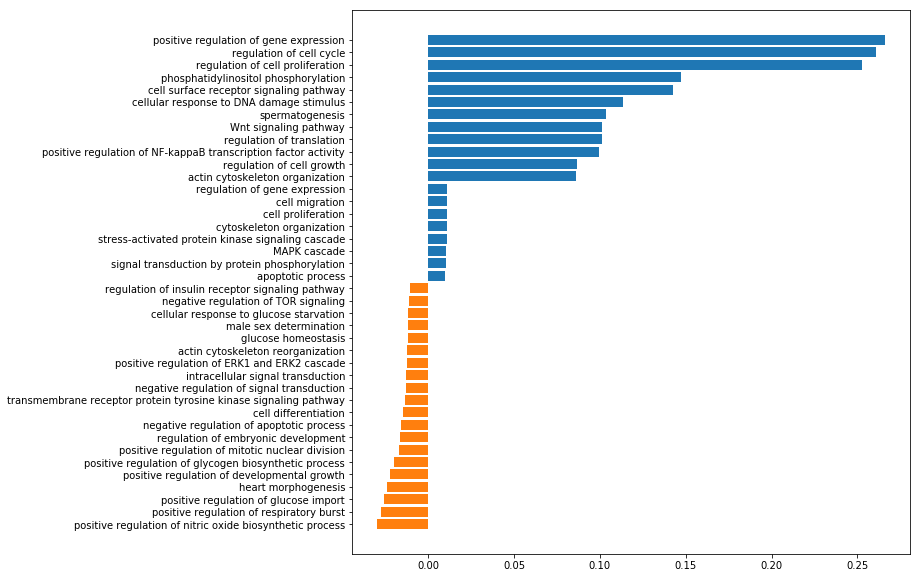

In [105]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 0), axis=0), names=feat)

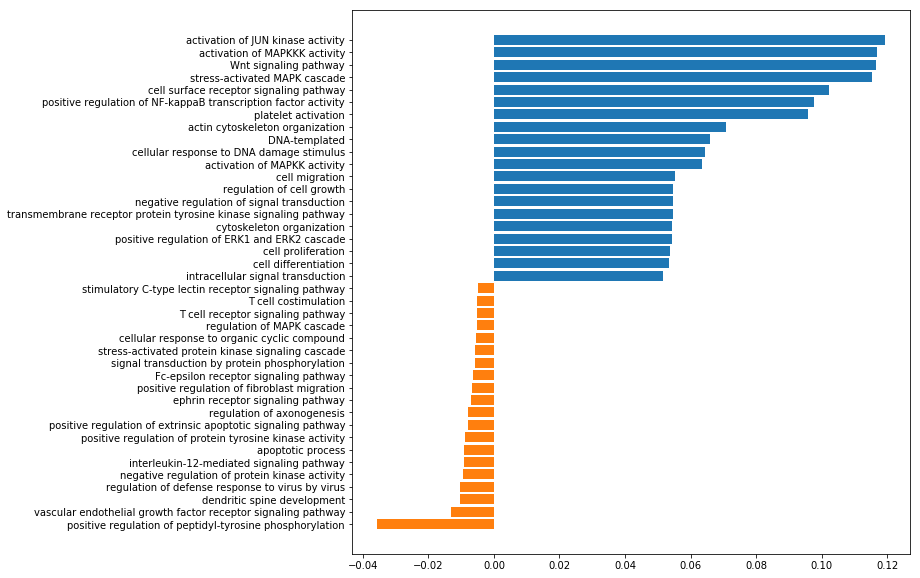

In [106]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 1), axis=0), names=feat)

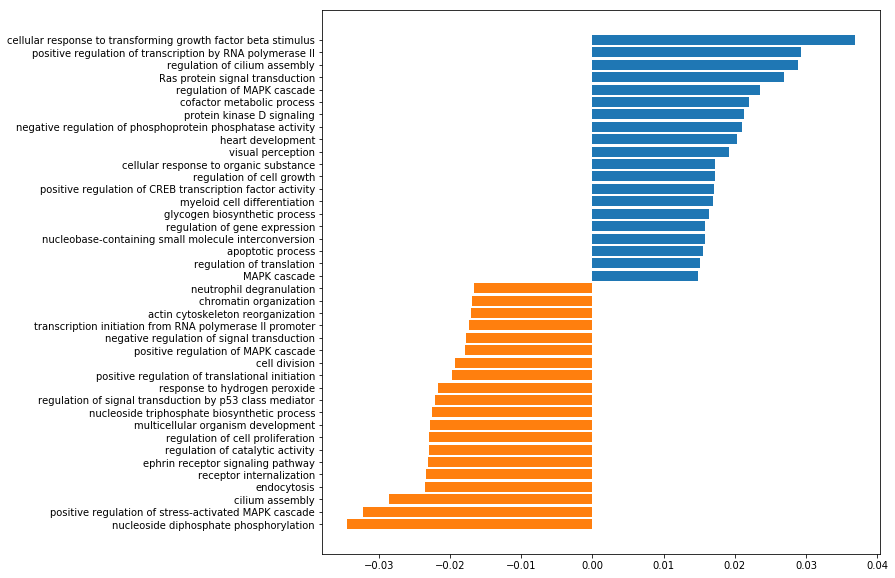

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 7), axis=0), names=feat)

In [121]:
set(filter(lambda x: 'apoptotic' in x, [term for doc in go_annotations for term in doc]))

{'B cell apoptotic process',
 'T cell apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic process',
 'activation of cysteine-type endopeptidase activity involved in apoptotic signaling pathway',
 'apoptotic cell clearance',
 'apoptotic mitochondrial changes',
 'apoptotic nuclear changes',
 'apoptotic process',
 'apoptotic signaling pathway',
 'endothelial cell apoptotic process',
 'extrinsic apoptotic signaling pathway',
 'extrinsic apoptotic signaling pathway in absence of ligand',
 'extrinsic apoptotic signaling pathway via death domain receptors',
 'fibroblast growth factor receptor apoptotic signaling pathway',
 'hepatocyte apoptotic process',
 'intrinsic apoptotic signaling pathway',
 'intrinsic apoptotic signaling pathway by p53 class mediator',
 'intrinsic apoptotic signaling pathway in response to DNA damage',
 'intrinsic apoptotic signaling pathway in response to DNA damage by p53 class mediator',
 'intrinsic apoptotic signaling pathw

In [122]:
location = np.where(freq_go_lab_binner.transform(['apoptotic process']))[1][0]
print(location)

95


In [123]:
m_scores = []
for i in range(57):
    try:
        m = np.mean(get_svm_coeffs_for_cluster(svm, i), axis=0)[location]
    except:
        m = 0
        
    m_scores.append(m)

m_scores = np.array(list(filter(lambda x: np.isfinite(x), m_scores)))

In [124]:
low_value = np.percentile(np.array(m_scores), 5)
high_value = np.percentile(np.array(m_scores), 95)

print(low_value)
print(high_value)


-0.038456293832351045
0.02448517619132056


In [125]:
low_clusts = [x for x,y in enumerate(m_scores) if y < low_value]
low_clusts

[34, 40, 55]

In [126]:
high_clusts = [x for x,y in enumerate(m_scores) if y > high_value]
high_clusts

[1, 3, 50]

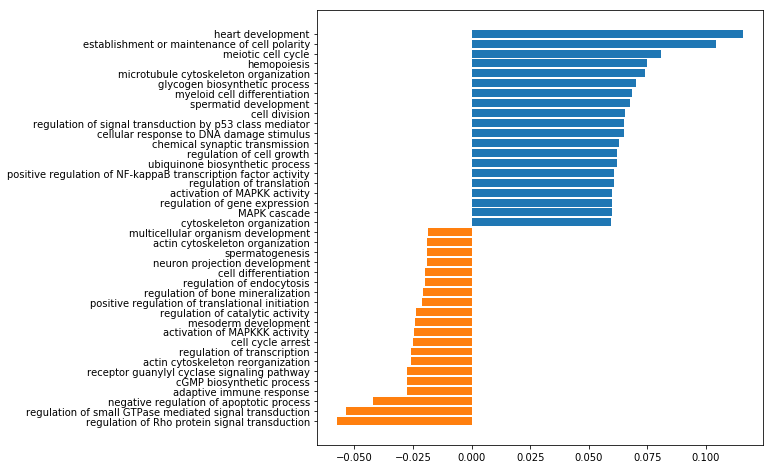

In [131]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 3), axis=0), names=feat)

In [146]:
c_spinglass_clusters = pd.read_csv(cluster_dir+c_spinglass_file, sep = '\t')
c_spinglass_clusters#.groupby('cluster')['names'].apply(len)

,names,cluster
0,PAK1,1
1,ERBB2,2
2,RON,3
3,YES,3
4,TYRO3,3
5,LYN,3
6,KIT,2
7,KPCA,4
8,SRC,3
9,MATK,3


In [148]:
from scipy.stats import hypergeom
understudied = pd.read_csv('understudied_kinases.csv', header=None)[0].tolist()

def test_understudied(clust, understudied, M):
    N = len(clust)
    
    rv = hypergeom(M, len(understudied), N)
    
    k = sum(map(lambda x: x in understudied, clust))
    
    return rv.pmf(k)

In [156]:
understudied_p_vals = []
for i in c_spinglass_clusters['cluster'].unique():
    p_val = test_understudied(c_spinglass_clusters[c_spinglass_clusters['cluster']==i]['names'], understudied, M=473)
    understudied_p_vals.append(p_val)

In [160]:
understudied_clusts = []
for loc, p_val in enumerate(understudied_p_vals):
    if(p_val < 0.05):
        understudied_clusts += [loc]
        
print(understudied_clusts)

[1, 2, 5, 11, 12, 23, 41, 44]


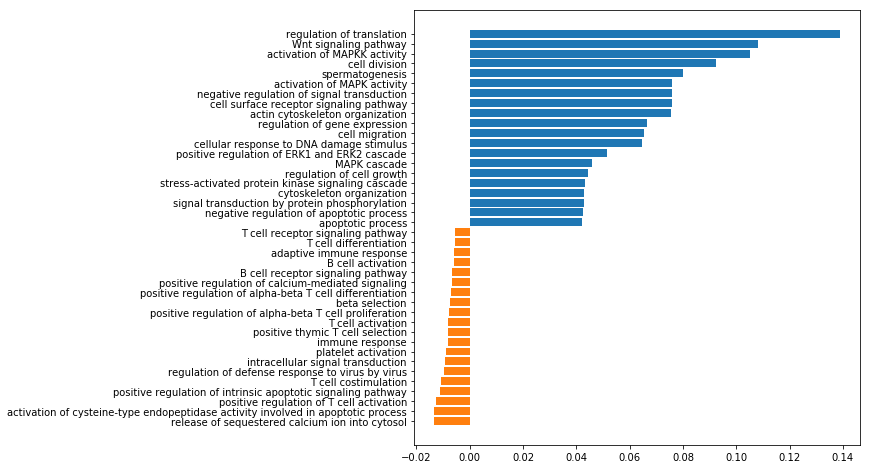

In [167]:
fig, ax = plt.subplots(figsize=(8,8))
f_importances(coef=np.mean(get_svm_coeffs_for_cluster(svm, 5), axis=0), names=feat)

In [164]:
c_spinglass_clusters[c_spinglass_clusters['cluster']==5]

,names,cluster
12,KSYK,5
19,BTK,5
47,ZAP70,5
122,LCK,5


In [175]:
spin = c_spinglass_clusters.set_index('names')
fast = pd.read_csv(cluster_dir+fast_greedy_file, sep='\t',index_col=0)

Below is the fast_greedy membership of each c_spinglass cluster

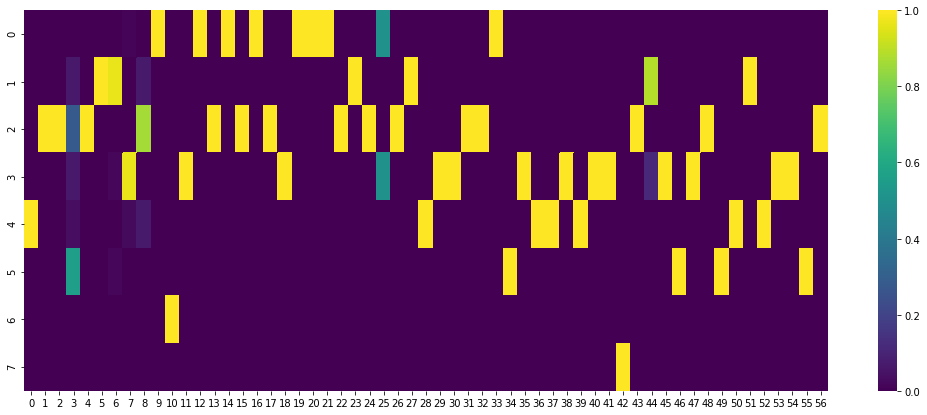

In [309]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(18,7))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

Below is the c_spinglass membership of each fast_greedy cluster

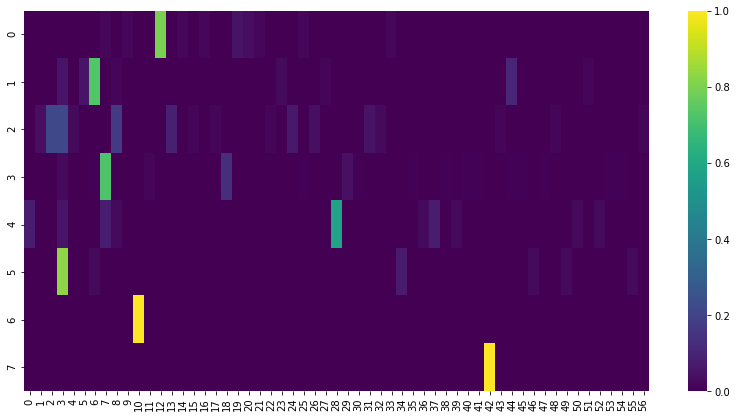

In [291]:
cont_mat = pd.DataFrame(contingency_matrix(fast, spin))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=1),axis = 0)

fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(cont_mat, ax=ax, cmap='viridis')